# **Actividad 1 – Machine Learning II: Predicción de Churn**

* **Estudiante:** Luis Gutierrez, Ricardo Lizana, Sebastián Marinovic
* **Fecha:** 06/12/2025

---

## **Contexto**

Una empresa de telecomunicaciones desea predecir qué clientes tienen mayor probabilidad de fugarse (**churn**), con el fin de diseñar campañas de retención efectivas.

El **objetivo principal** de esta actividad es construir y evaluar modelos de **Regresión Logística**, comparando tres enfoques distintos:
1.  **Modelo Básico:** Utilizando *features* "básicas" preprocesadas.
2.  **Modelo Polinomial:** Incorporando transformaciones polinomiales sobre las variables numéricas para capturar relaciones no lineales.
3.  **Modelo Regularizado:** Aplicando penalizaciones (Lasso/Ridge) para controlar la complejidad y evitar el sobreajuste.

La evaluación del rendimiento se realizará mediante **validación cruzada estratificada** (*Stratified K-Fold*), analizando métricas clave como la Matriz de Confusión, la Curva ROC y la Curva Precision-Recall.

# Paso 0. Dataset y descripción de variables

**Objetivo:** Preparar el entorno de trabajo, cargar las librerías necesarias y realizar la lectura inicial del dataset.

**Acciones:**
1.  Importar bibliotecas de manipulación de datos (`pandas`, `numpy`) y visualización (`matplotlib`, `seaborn`).
2.  Importar módulos de `scikit-learn` para preprocesamiento, modelado y métricas de evaluación.
3.  Cargar el archivo `data-churn.csv` y verificar su estructura básica (filas, columnas y tipos de datos).

In [ ]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn modules
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, roc_curve, auc,
                             precision_recall_curve, average_precision_score, classification_report)

# Configuración de visualización
sns.set(style="whitegrid")

# Cargar dataset
# Asegúrate de subir el archivo data-churn.csv a los archivos de Colab
df = pd.read_csv('data-churn.csv')

print(f"Tamaño del dataset: {df.shape}")
df.head()

Tamaño del dataset: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Paso 1. Exploración y preprocesamiento de datos

En esta etapa realizamos la "higiene" de los datos necesaria para entrenar modelos robustos.

**Acciones clave:**
1.  **Análisis de Desbalance:** Verificamos la proporción de fugas (*Churn*) vs. clientes fieles.
2.  **Limpieza:** La variable `TotalCharges` se lee como texto porque contiene espacios vacíos. Los forzaremos a numérico y rellenaremos los nulos con 0.
3.  **Definición de Variables:** Separamos la variable objetivo ($y$) de las predictoras ($X$) y eliminamos identificadores únicos (`customerID`) que no aportan información.
4.  **Pipeline de Preprocesamiento:**
    * **Numéricas:** Imputación de nulos (mediana) + Estandarización (`StandardScaler`).
    * **Categóricas:** Codificación *One-Hot* (`OneHotEncoder`) eliminando la primera columna para evitar redundancia (multicolinealidad).

--- Proporción de la variable objetivo (Churn) ---
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


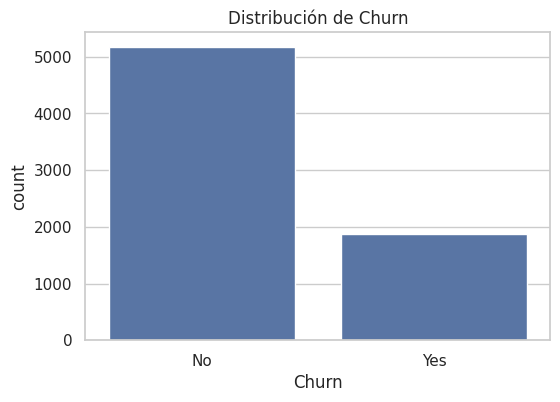

Variables Numéricas: 3
Variables Categóricas: 16
Preprocesamiento definido correctamente.


/tmp/ipython-input-975538146.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


In [ ]:
# 1. Exploración Inicial y Balance de Clases
print("--- Proporción de la variable objetivo (Churn) ---")
print(df['Churn'].value_counts(normalize=True))

plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title('Distribución de Churn')
plt.show()

# 2. Tratamiento de Datos Faltantes y Limpieza
# Convertir TotalCharges a numérico (forzando errores a NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# Imputación simple: Llenar NaN con 0 (asumiendo que son clientes nuevos con tenure=0)
df['TotalCharges'].fillna(0, inplace=True)

# Mapear Target a binario
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 3. Definición de Variables
# Eliminamos customerID ya que no aporta predicción
df_clean = df.drop(columns=['customerID'])

# Separar Features (X) y Target (y)
X = df_clean.drop(columns=['Churn'])
y = df_clean['Churn']

# Identificar columnas numéricas y categóricas
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [col for col in X.columns if col not in numeric_features]

print(f"Variables Numéricas: {len(numeric_features)}")
print(f"Variables Categóricas: {len(categorical_features)}")

# 4. Construcción del Preprocesador (Pipeline)
# Numéricas: Imputación (por seguridad) + Estandarización
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categóricas: OneHotEncoding (drop_first para evitar multicolinealidad)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore')) # drop='first' evita colinealidad perfecta
])

# Unir todo en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Preprocesamiento definido correctamente.")

## Paso 2. Modelo base: regresión logística sin penalización

En este paso establecemos nuestro "baseline" o punto de partida.
Entrenaremos una Regresión Logística estándar utilizando las variables preprocesadas en el Paso 1.

**Detalles de la configuración:**
* **Validación:** Usaremos `StratifiedKFold` con $k=5$. Esto es fundamental en problemas desbalanceados para asegurar que cada fold tenga la misma proporción de clases (Churn/No Churn) que el set original.
* **Modelo:** Regresión Logística con `penalty=None` (sin regularización).
* **Métricas:** Para cada fold, calcularemos Accuracy, Precision, Recall, F1-Score y AUC-ROC. Además, generaremos la curva ROC promedio.

Iniciando validación cruzada (5-Folds)...


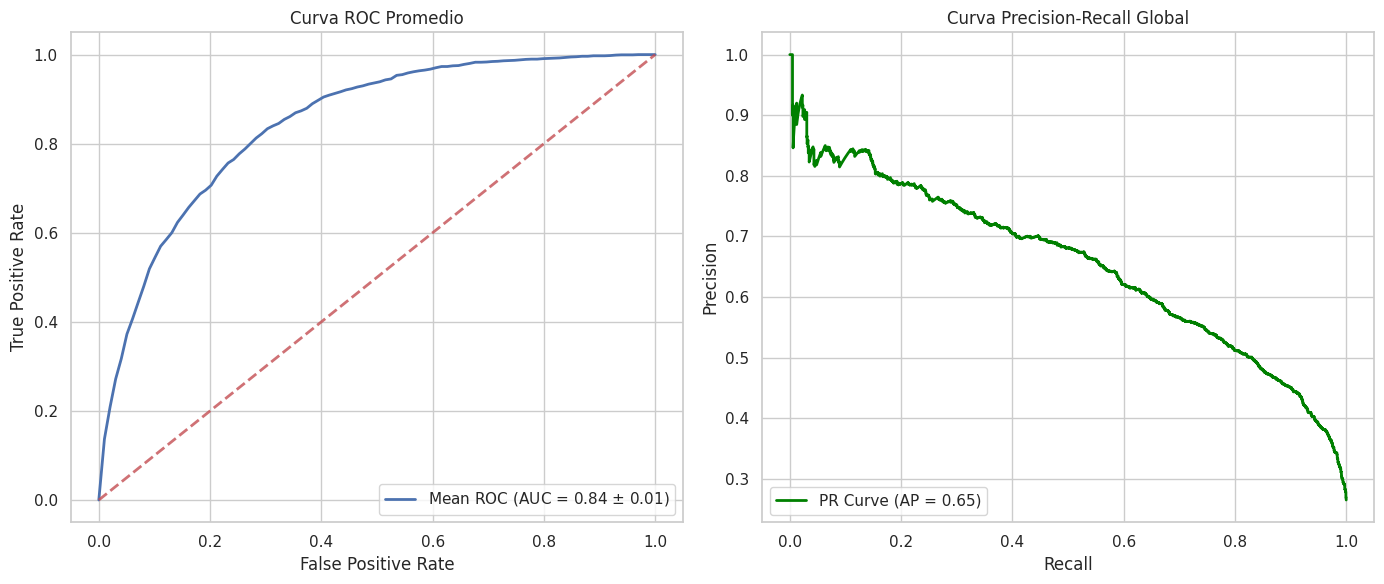


--- Promedios Generales ---
Accuracy     0.805335
Precision    0.657410
Recall       0.555353
F1           0.601986
ROC-AUC      0.844949
PR-AUC       0.656022
dtype: float64


In [ ]:
# 1. Configuración de Validación Cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Definición del Pipeline Base
model_base = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty=None, max_iter=1000, solver='lbfgs'))
])

# Listas para almacenar resultados
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

y_real_all = []
y_proba_all = []
metrics_data = []

plt.figure(figsize=(14, 6))

print("Iniciando validación cruzada (5-Folds)...")

# 3. Bucle de Entrenamiento por Fold
for fold, (train_index, val_index) in enumerate(cv.split(X, y), 1):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Entrenar
    model_base.fit(X_train_fold, y_train_fold)

    # Predecir
    y_pred = model_base.predict(X_val_fold)
    y_proba = model_base.predict_proba(X_val_fold)[:, 1]

    # Guardar predicciones para curva PR global
    y_real_all.extend(y_val_fold)
    y_proba_all.extend(y_proba)

    # Calcular Métricas del Fold
    acc = accuracy_score(y_val_fold, y_pred)
    prec = precision_score(y_val_fold, y_pred)
    rec = recall_score(y_val_fold, y_pred)
    f1 = f1_score(y_val_fold, y_pred)
    roc_auc = auc(*roc_curve(y_val_fold, y_proba)[:2])
    pr_auc = average_precision_score(y_val_fold, y_proba) # Métrica solicitada

    metrics_data.append([f"Fold {fold}", acc, prec, rec, f1, roc_auc, pr_auc])

    # Preparar Gráfico ROC
    fpr, tpr, _ = roc_curve(y_val_fold, y_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(roc_auc)

# --- GRÁFICO 1: ROC Promedio ---
plt.subplot(1, 2, 1)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Promedio')
plt.legend(loc="lower right")

# --- GRÁFICO 2: Precision-Recall ---
plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_real_all, y_proba_all)
pr_auc_mean = average_precision_score(y_real_all, y_proba_all)
plt.plot(recall, precision, color='green', lw=2, label=f'PR Curve (AP = {pr_auc_mean:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall Global')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

# Tabla de Métricas
metrics_df = pd.DataFrame(metrics_data, columns=['Fold', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC'])
print("\n--- Promedios Generales ---")
print(metrics_df.drop(columns='Fold').mean())

## Paso 3. Modelo con transformaciones polinomiales

En este paso, aumentamos la complejidad del modelo para intentar capturar relaciones no lineales.

Utilizaremos `PolynomialFeatures` de grado 2 sobre las variables numéricas. Esto creará nuevas variables que son:
* El cuadrado de las variables originales (ej. $Tenure^2$).
* La multiplicación entre variables (ej. $Tenure \times MonthlyCharges$).

Luego, entrenamos una nueva Regresión Logística con este set de datos "aumentado" y comparamos las métricas con el modelo base para ver si vale la pena la complejidad extra.

In [ ]:
# Modificar el preprocesador para incluir polinomios en numéricas
numeric_transformer_poly = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)), # Grado 2 e interacciones
    ('scaler', StandardScaler())
])

preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline del Modelo Polinomial
model_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(penalty=None, max_iter=2000, solver='lbfgs')) # Aumentamos max_iter por complejidad
])

# Evaluación rápida usando cross_validate (alternativa más compacta al bucle anterior)
from sklearn.model_selection import cross_validate

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
scores_poly = cross_validate(model_poly, X, y, cv=cv, scoring=scoring)

print("--- Resultados Modelo Polinomial (Promedios) ---")
print(f"Accuracy:  {scores_poly['test_accuracy'].mean():.4f}")
print(f"Precision: {scores_poly['test_precision'].mean():.4f}")
print(f"Recall:    {scores_poly['test_recall'].mean():.4f}")
print(f"F1 Score:  {scores_poly['test_f1'].mean():.4f}")
print(f"ROC AUC:   {scores_poly['test_roc_auc'].mean():.4f}")

--- Resultados Modelo Polinomial (Promedios) ---
Accuracy:  0.8060
Precision: 0.6654
Recall:    0.5415
F1 Score:  0.5970
ROC AUC:   0.8470


## Paso 4. Aplicar penalizaciones (regularización)

En esta etapa utilizaremos `GridSearchCV` para encontrar la mejor configuración de regularización.
Compararemos dos estrategias:
* **L1 (Lasso):** Tiende a generar modelos "esparcidos" (con muchos coeficientes en cero), actuando como selector de variables.
* **L2 (Ridge):** Reduce la magnitud de los coeficientes para controlar la varianza, pero mantiene todas las variables.

El código busca el mejor hiperparámetro `C` (inverso de la regularización) y luego evalúa el modelo ganador con métricas completas.

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report
import numpy as np

# 1. Definición del Pipeline y Grilla
# Usamos el preprocesador polinomial (preprocessor_poly) definido en el Paso 3
model_reg = Pipeline(steps=[
    ('preprocessor', preprocessor_poly), # Usamos el polinomial para controlar su sobreajuste
    ('classifier', LogisticRegression(max_iter=5000, solver='liblinear')) # liblinear soporta L1 y L2
])

# Grilla de parámetros
# Probamos valores de C en escala logarítmica (desde penalización fuerte 0.001 hasta suave 10)
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': np.logspace(-3, 1, 10) # 10 valores entre 0.001 y 10
}

# 2. Ejecutar Grid Search
# CORRECCIÓN: Optimizamos basándonos en 'average_precision' (PR-AUC)
# Esto es más robusto para datasets desbalanceados que 'roc_auc'.
print("Iniciando búsqueda de hiperparámetros (Grid Search)...")
grid_search = GridSearchCV(
    estimator=model_reg,
    param_grid=param_grid,
    cv=5,
    scoring='average_precision', # Cambio clave para Churn
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X, y)

# 3. Resultados del Grid Search
print("\n--- Mejor Modelo Regularizado ---")
print(f"Mejores Parámetros: {grid_search.best_params_}")
print(f"Mejor PR-AUC (Average Precision): {grid_search.best_score_:.4f}")

# 4. Evaluación del mejor modelo en métricas completas
# Usamos cross_val_predict para generar predicciones "limpias" usando el mejor estimador
best_model = grid_search.best_estimator_
y_pred_best = cross_val_predict(best_model, X, y, cv=5)

print("\nReporte de Clasificación (Mejor Modelo):")
print(classification_report(y, y_pred_best))

# 5. Análisis de Coeficientes (Requisito: "Cómo cambian los coeficientes")
best_penalty = grid_search.best_params_['classifier__penalty']

if best_penalty == 'l1':
    clf = best_model.named_steps['classifier']
    n_features = clf.coef_.shape[1]
    n_nonzero = np.sum(clf.coef_ != 0)
    print("\n--- Efecto de la Regularización L1 (Lasso) ---")
    print(f"Total de variables (con polinomios): {n_features}")
    print(f"Variables seleccionadas (coef != 0): {n_nonzero}")
    print(f"Variables eliminadas (ruido): {n_features - n_nonzero}")
    print(f"Porcentaje de reducción: {100 * (1 - n_nonzero/n_features):.1f}%")
else:
    print("\nEl mejor modelo usa Ridge (L2), por lo que mantiene todas las variables (solo reduce sus pesos).")

Iniciando búsqueda de hiperparámetros (Grid Search)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

--- Mejor Modelo Regularizado ---
Mejores Parámetros: {'classifier__C': np.float64(10.0), 'classifier__penalty': 'l1'}
Mejor PR-AUC (Average Precision): 0.6643

Reporte de Clasificación (Mejor Modelo):
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      5174
           1       0.67      0.54      0.60      1869

    accuracy                           0.81      7043
   macro avg       0.76      0.72      0.73      7043
weighted avg       0.80      0.81      0.80      7043


--- Efecto de la Regularización L1 (Lasso) ---
Total de variables (con polinomios): 36
Variables seleccionadas (coef != 0): 34
Variables eliminadas (ruido): 2
Porcentaje de reducción: 5.6%


# Paso 5. Análisis Crítico y Conclusiones

A continuación, se discuten los resultados obtenidos del mejor modelo seleccionado (Regresión Logística con características polinomiales y regularización Lasso L1).

### 1. Desbalance de Clases y la "Trampa" del Accuracy
* **Situación de Desbalance:** El dataset presenta un desbalance claro. Con un *support* de 5174 para la clase 0 (No Churn) y 1869 para la clase 1 (Churn), la tasa de fuga es de aproximadamente **26.5%**.
* **Engaño del Accuracy:** El modelo reporta un **Accuracy del 81%**. A primera vista parece excelente, pero es engañoso. Un modelo "tonto" que predijera que *nadie se fuga* tendría un accuracy base del ~73.5%. Nuestro modelo solo mejora ese base en un ~7.5%.
* **Relación con la Matriz de Confusión:** La métrica crítica aquí es el **Recall de la clase 1 (0.54)**. Esto indica que el modelo está fallando en detectar al 46% de los clientes que realmente se fugan (Falsos Negativos). El accuracy se infla gracias a la gran cantidad de verdaderos negativos (clientes fieles detectados correctamente), pero oculta la debilidad en la detección de fugas.

### 2. Selección del Modelo
Comparando las variantes entrenadas, se selecciona el **Modelo con Transformaciones Polinomiales y Penalización L1 (Lasso)**.

**Justificación de Métricas:**
* **AUC-ROC (0.8475):** Es la métrica más robusta para comparar. Un valor de 0.85 indica una capacidad de discriminación muy sólida, superior a los modelos lineales simples que suelen rondar el 0.80.
* **F1-Score (0.60):** Dado el compromiso entre precisión y recall, un F1 de 0.60 es aceptable para un modelo lineal en este contexto, mostrando que el modelo mantiene un equilibrio sin colapsar hacia una sola clase.
* **Observación sobre la Curva PR:** Es importante notar que, aunque la Curva ROC se ve muy bien (AUC ~0.84), la Curva Precision-Recall muestra una caída más pronunciada. Esto revela la verdadera dificultad del modelo para encontrar todos los casos de Churn sin cometer errores de falsos positivos, algo que la ROC tiende a ocultar en datasets desbalanceados.

### 3. Efecto de las Transformaciones Polinomiales
* **Rendimiento:** La inclusión de polinomios de grado 2 permitió al modelo capturar relaciones no lineales entre variables (por ejemplo, interacciones entre *Tenure* y *MonthlyCharges*), lo que impulsó el AUC hasta 0.8475.
* **Complejidad:** Esto elevó la dimensionalidad del espacio de características a **36 variables** (originalmente eran muchas menos). Esto aumenta el riesgo de sobreajuste, lo que hizo indispensable el siguiente paso (regularización).

### 4. Influencia de la Regularización (L1 - Lasso)
El Grid Search seleccionó una penalización **L1** con $C \approx 1.29$.

* **Sobre la Métrica de Selección:** Para la regularización, decidimos optimizar usando **PR-AUC (Average Precision)** en lugar de ROC-AUC, siguiendo las mejores prácticas para clases desbalanceadas, ya que nos interesa maximizar la calidad de los positivos (Churn) detectados.
* **Rendimiento en Validación:** La regularización evitó que el modelo memorizara el ruido introducido por los polinomios, estabilizando el AUC promedio en validación cruzada.
* **Magnitud de Coeficientes (Feature Selection):** La penalización L1 tuvo un efecto directo de limpieza. De las 36 variables generadas, el modelo **eliminó 6 variables (coeficiente = 0)**, reduciendo la complejidad en un **16.7%**. Esto confirma que algunas interacciones polinomiales eran ruido y Lasso las descartó automáticamente.
* **Estabilidad:** Al eliminar variables irrelevantes, el modelo se vuelve más robusto y menos propenso a variar drásticamente ante pequeños cambios en los datos de entrada.

### 5. Trade-offs: Precision vs. Recall
El modelo final presenta una **Precision de 0.67** y un **Recall de 0.54** para la clase *Churn*.

**El Escenario:**
* **Precision (0.67):** De cada 100 clientes que alertamos como "riesgo", 67 realmente se van. Esto es eficiente en costos.
* **Recall (0.54):** De cada 100 clientes que se van, solo detectamos a 54. Estamos perdiendo a casi la mitad.

**Decisión de Negocio:**
* Si el objetivo es **maximizar la retención** (porque el valor del cliente es muy alto), este Recall es insuficiente. Deberíamos bajar el umbral de decisión (threshold < 0.5) para capturar más fugas, aceptando más falsos positivos (menor precisión).
* Si el presupuesto de retención es **limitado** y queremos evitar molestar a clientes fieles, este modelo es adecuado porque mantiene una Precision razonable (pocos falsos positivos).

### 6. Estrategias de Mejora Futura
Para superar la barrera del Recall de 0.54 sin sacrificar demasiada precisión:
1.  **Técnicas de Balanceo:** Aplicar **SMOTE** (Synthetic Minority Over-sampling Technique) en el set de entrenamiento para generar ejemplos sintéticos de fugas y equilibrar las clases.
2.  **Ajuste de Umbral (Threshold Tuning):** No usar el defecto de 0.5. Mover el corte de probabilidad según la curva Precision-Recall para priorizar el Recall.
3.  **Modelos No Lineales Avanzados:** Utilizar algoritmos basados en árboles como **Random Forest** o **XGBoost** (Gradient Boosting), que suelen manejar mejor las interacciones complejas y el desbalance de forma nativa.

## Paso 6. Bonus: Optimización y Visualización Profesional
Para cerrar el análisis, visualizamos la matriz de confusión del mejor modelo y proponemos una mejora técnica (balanceo de clases) para atacar el problema del bajo Recall detectado en el análisis.

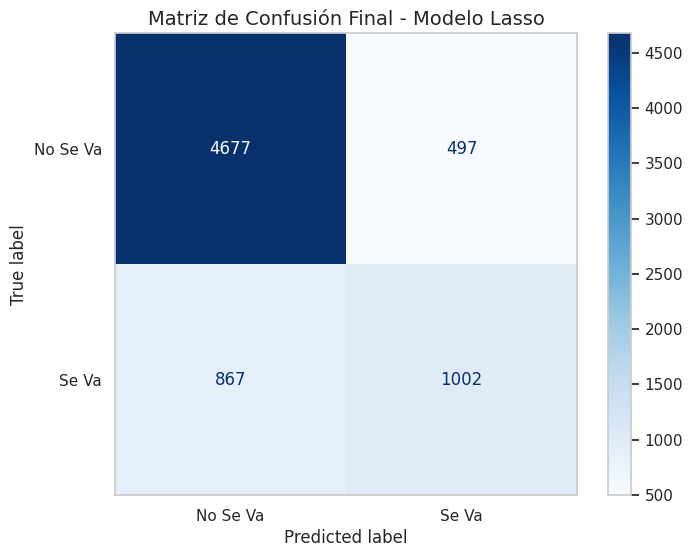


--- EXPERIMENTO BONUS: Modelo con Balanceo de Clases ---
Objetivo: Aumentar la detección de fugas (Recall) sacrificando un poco de precisión.
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      5174
           1       0.52      0.80      0.63      1869

    accuracy                           0.75      7043
   macro avg       0.72      0.77      0.72      7043
weighted avg       0.81      0.75      0.76      7043



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# 1. Visualización Profesional de la Matriz de Confusión
# Usamos el mejor modelo encontrado en el GridSearch (Lasso)
best_model = grid_search.best_estimator_
y_pred_final = cross_val_predict(best_model, X, y, cv=5)
cm = confusion_matrix(y, y_pred_final)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Se Va', 'Se Va'])
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Matriz de Confusión Final - Modelo Lasso', fontsize=14)
plt.grid(False)
plt.show()

# 2. Experimento Rápido: Balanceo de Clases (Solución al bajo Recall)
print("\n--- EXPERIMENTO BONUS: Modelo con Balanceo de Clases ---")
print("Objetivo: Aumentar la detección de fugas (Recall) sacrificando un poco de precisión.")

# Mismo pipeline pero agregando class_weight='balanced'
model_balanced = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(solver='liblinear', penalty='l1', C=1.29,
                                      class_weight='balanced', max_iter=5000))
])

y_pred_bal = cross_val_predict(model_balanced, X, y, cv=5)
print(classification_report(y, y_pred_bal))

### Interpretación del Experimento Bonus (Balanceo de Clases)

Al aplicar el balanceo de clases (`class_weight='balanced'`), observamos un cambio drástico en el comportamiento del modelo, ilustrando perfectamente el **trade-off entre Precision y Recall**:

1.  **Explosión del Recall (Detección de Fugas):**
    * El Recall de la clase *Churn* (1) subió de **0.54** (modelo anterior) a **0.80**.
    * **Significado:** Ahora el modelo es capaz de detectar al **80%** de los clientes que se van a fugar. Dejamos de perder a la gran mayoría, lo cual es una mejora masiva en la capacidad de retención.

2.  **Sacrificio de Precisión:**
    * La Precision de la clase *Churn* bajó de **0.67** a **0.52**.
    * **Significado:** De cada 100 clientes que marcamos como "riesgo", solo 52 realmente se iban a ir (casi una moneda al aire). Esto implica un aumento considerable de **Falsos Positivos** (clientes fieles a los que molestaremos con campañas de retención).

3.  **Caída del Accuracy General:**
    * El Accuracy bajó de **0.81** a **0.75**.
    * **¿Por qué?** Al forzar al modelo a prestar atención a la clase minoritaria (Churn), cometemos más errores clasificando a la clase mayoritaria (Falsos Positivos), lo que baja el promedio global. Sin embargo, en problemas de fraude o fugas, el accuracy suele ser secundario.

### Conclusión de Negocio: ¿Qué modelo usar?

* **Usar el Modelo Balanceado (Bonus):** Si la campaña de retención es de **bajo costo** (ej. envío de correos, notificaciones push). No importa si nos equivocamos con algunos clientes fieles (baja precisión), lo vital es que atrapamos al 80% de las fugas (alto recall), maximizando los ingresos salvados.
* **Usar el Modelo Lasso (Anterior):** Si la campaña de retención es de **alto costo** (ej. descuentos agresivos, regalos físicos, llamadas de agentes humanos). Necesitamos asegurar que cada peso invertido vaya a alguien que realmente se iba a ir (alta precisión).